In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pkg_resources

from debvader.model import load_deblender
from debvader.deblender import deblend, DeblendField
from debvader.detection import detect_objects
from debvader.extraction import extract_cutouts

2022-03-02 15:30:18.538638: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-03-02 15:30:18.538696: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Deblend stamps randomly generated from DC2 data

Load 10 DC2 images centred on galaxy. They have been generated using this notebook: https://github.com/BastienArcelin/dc2_img_generation/blob/main/notebooks/dc2_stamps_and_corresponding_parameters.ipynb

In [2]:
data_path = pkg_resources.resource_filename('debvader', "data/")
image_path = os.path.join(data_path + 'dc2_imgs/imgs_dc2.npy')
images = np.load(image_path, mmap_mode = 'c')

Visualize some of the images

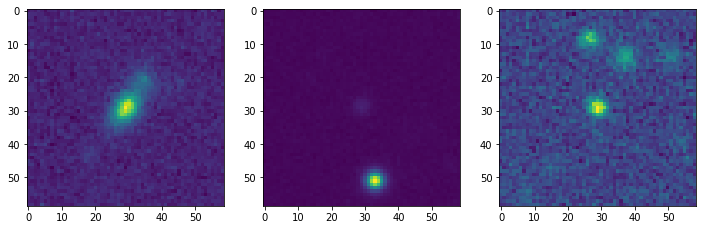

In [3]:
fig, axes = plt.subplots(1,3, figsize = (12, 4))
for i in range (3):
    axes[i].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)

Now we can load the deblender

In [4]:
# First, define the parameters of the neural network, for this version of debvader, they are as follow:
nb_of_bands = 6
input_shape = (59, 59, nb_of_bands)
latent_dim = 32
filters = [32,64,128,256]
kernels = [3,3,3,3]

# We will load the weights of the network trained on DC2 images
survey = "dc2"

In [5]:
# Load the network using the load_deblender function
net, encoder, decoder, z = load_deblender(survey=survey, 
                                          input_shape=input_shape,
                                          latent_dim=latent_dim, 
                                          filters=filters, 
                                          kernels=kernels, 
                                          return_encoder_decoder_z=True)

2022-03-02 15:30:28.850851: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-03-02 15:30:28.850915: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-02 15:30:28.850963: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-03-02 15:30:28.851322: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-02 1

in cropping
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf

2022-03-02 15:30:30.102668: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


weights loaded from: /pbs/throng/lsst/users/bbiswas/debvader/debvader/data/weights/dc2/not_normalised/loss


In [6]:
# We can visualize the network
net.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 59, 59, 6)]       0         
_________________________________________________________________
functional_1 (Functional)    (None, 560)               3741224   
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 32), (None, 32))  0         
_________________________________________________________________
functional_3 (Functional)    (None, 59, 59, 6)         4577228   
Total params: 8,318,452
Trainable params: 3,741,212
Non-trainable params: 4,577,240
_________________________________________________________________


We now have everything to do the deblending. Let's use our network to deblend the DC2 images

In [7]:
output_images_mean, output_images_distribution = deblend(net, images)

Here the network outputs a distribution over the pixels for each pixel in each filter, this is why both the mean image and the corresponding distribution is outputed.

Let's first visualize the mean images outputed by debvader.

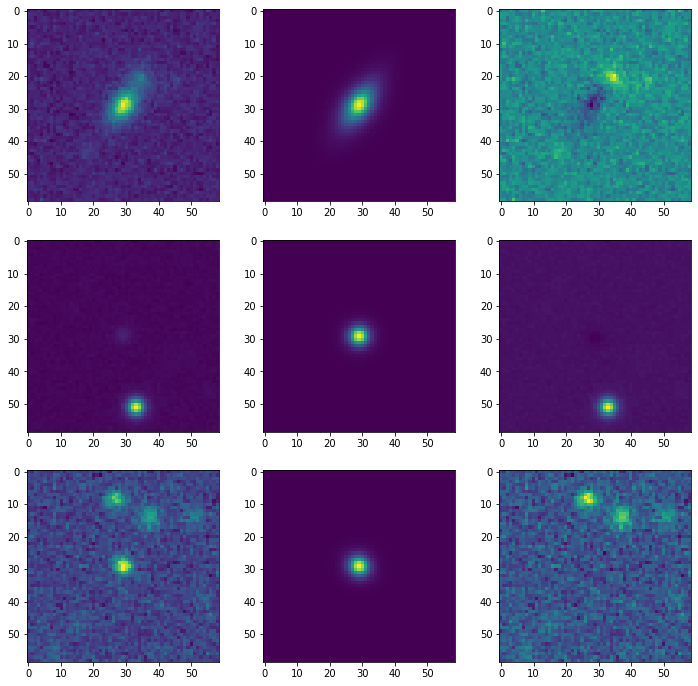

In [8]:
fig, axes = plt.subplots(3,3, figsize = (12, 12))
for i in range (3):
    axes[i,0].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)
    axes[i,1].imshow(output_images_mean[i,:,:,2]) # We plot only r-band here, but the output images are multi-bands (ugrizy)
    axes[i,2].imshow(images[i,:,:,2]-output_images_mean[i,:,:,2])

Now we can look at what the images of the standard deviation look like for each example, and how we can sample this distribution in each pixel.

In [9]:
output_uncertainty_mean = output_images_distribution.mean().numpy() # Extract the mean of the distribution. Same image as output_images_mean.
output_uncertainty_std = output_images_distribution.stddev().numpy() # Extract the standard deviation of the distribution.
output_uncertainty_sample = tf.math.reduce_mean(output_images_distribution.sample(100), axis = 0).numpy() # Sample 100 times the distribution in each pixel and produce a mean image.

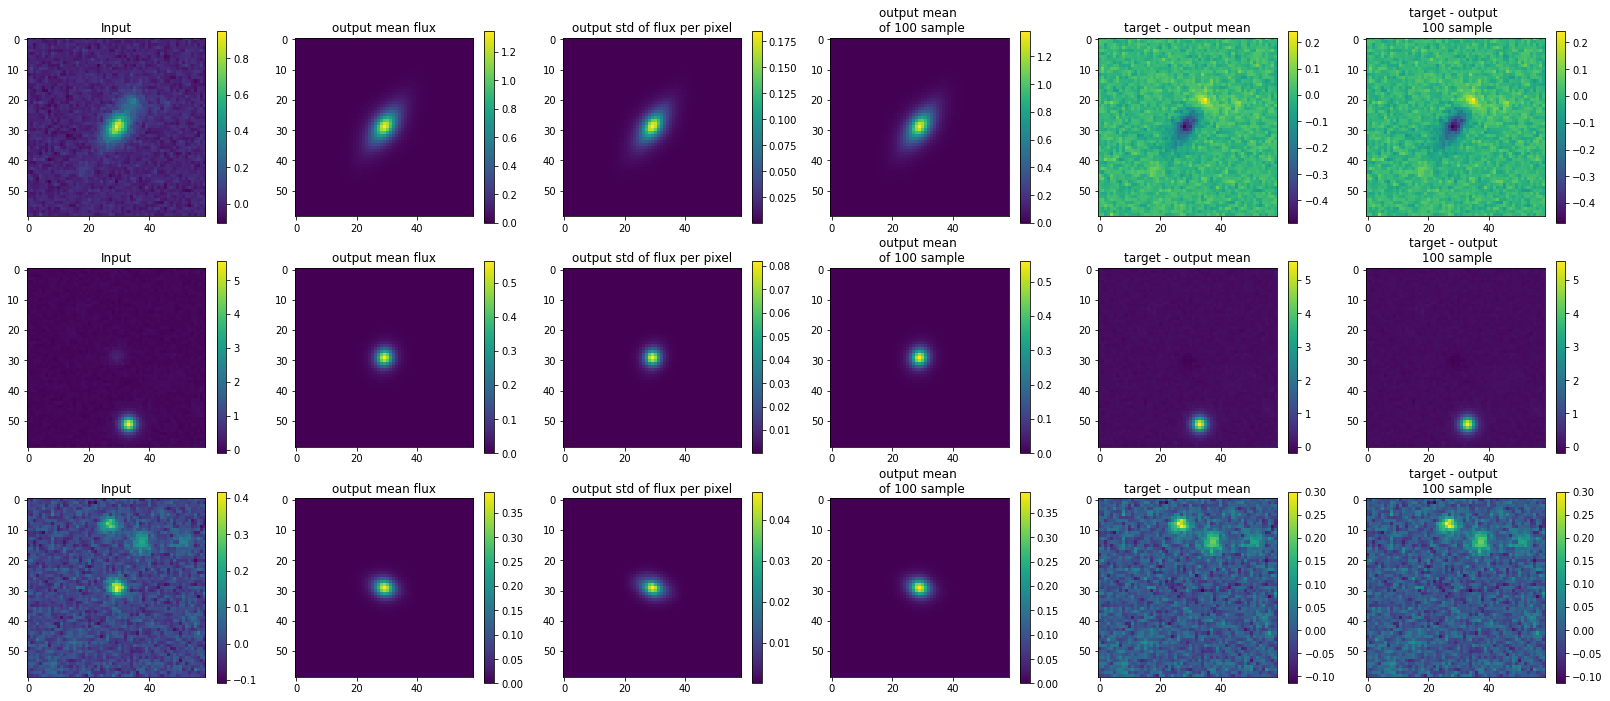

In [10]:
fig, axes = plt.subplots(3,6, figsize = (28, 12))

for i in range (3):
    f1 = axes[i,0].imshow(images[i,:,:,2])
    f2 = axes[i,1].imshow(output_uncertainty_mean[i,:,:,2])
    f3 = axes[i,2].imshow(output_uncertainty_std[i,:,:,2])
    f4 = axes[i,3].imshow(output_uncertainty_sample[i,:,:,2])
    f5 = axes[i,4].imshow(images[i,:,:,2] - output_uncertainty_mean[i,:,:,2])
    f6 = axes[i,5].imshow(images[i,:,:,2] - output_uncertainty_sample[i,:,:,2])
    fig.colorbar(f1, ax = axes[i,0])
    fig.colorbar(f2, ax = axes[i,1])
    fig.colorbar(f3, ax = axes[i,2])
    fig.colorbar(f4, ax = axes[i,3])
    fig.colorbar(f5, ax = axes[i,4])
    fig.colorbar(f6, ax = axes[i,5])

    axes[i,0].set_title('Input')
    axes[i,1].set_title('output mean flux')
    axes[i,2].set_title('output std of flux per pixel')
    axes[i,3].set_title('output mean \n of 100 sample')
    axes[i,4].set_title('target - output mean')
    axes[i,5].set_title('target - output \n 100 sample')

### Deblend a DC2 field

Load DC2 field image and corresponding galaxy stamps for galaxies that have a magnitude below 24.5 in the $r$-band, as well as the true galaxy centers on the field for galaxies with a magnitude below 26 in the $r$-band. They have been generated using this notebook: https://github.com/BastienArcelin/dc2_img_generation/blob/main/notebooks/dc2_stamps_and_corresponding_parameters.ipynb

In [11]:
data_folder_path = pkg_resources.resource_filename('debvader', "data/")

field_img = np.load(data_folder_path + 'dc2_imgs/field/field_img.npy', mmap_mode = 'c') # DC2 field image
cutout_galaxy_img = np.load(data_folder_path + 'dc2_imgs/field/galaxies_from_field.npy', mmap_mode = 'c') # stamps from galaxies below a magnitude of 24.5 in the r-band
field_galaxies_distances_from_center = np.load(data_folder_path + '/dc2_imgs/field/ra_dec_coord.npy', allow_pickle=True) # Distances from center of the different galaxies from object catalog (in pixels). Mag cut at 24.5
all_field_galaxies_distances_from_center_truth = np.load(data_folder_path + '/dc2_imgs/field/gal_coordinates_complete_truth_catalog.npy', allow_pickle=True) # Distances from center of the field for the galaxies from the DC2 truth catalog (in pixels). Mag cut at 26

field_img_saving_iter = field_img.copy()

Set parameters:

In [12]:
cutout_size = 59 # pixels
field_size = 259 # pixels
nb_of_bands = 6 # six LSST filters

#### Detection with SExtractor

We can also use the very common detection algorithm [SExtractor](https://articles.adsabs.harvard.edu/pdf/1996A%26AS..117..393B). Using the `detect_objects` function we can detect all the galaxies that are above `0.8` times the noise level in the image.

In [13]:
galaxy_distances_to_center_sep = detect_objects(field_img[0])

In [14]:
print("Number of galaxies detected by SExtractor : "+ str(len(galaxy_distances_to_center_sep)))

Number of galaxies detected by SExtractor : 74


#### Deblending the field with SExtractor detected galaxy positions

Feed the deblend_field with the required paramter, including the coordinates of the sources detected by SExtractor:

In [15]:
Deblender = DeblendField(net, field_img[0])
res_deblending_sep = Deblender.deblend_field(galaxy_distances_to_center_sep)

Some galaxies are too close from the border of the field to be considered here.


In [16]:
res_deblending_sep_meta = Deblender.get_deblending_meta_data()

In [17]:
print('On the '+ str(Deblender.nb_of_detected_objects[0]) +' galaxies detected by SExtractor, '+ str(Deblender.nb_of_deblended_galaxies[0])+' were actually deblended.')

On the 74 galaxies detected by SExtractor, 51 were actually deblended.


The function outputs both the initial field and the field subtracted from the deblended galaxies. It also provide an image of the model proposed by the deblender for the denoised field.

Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

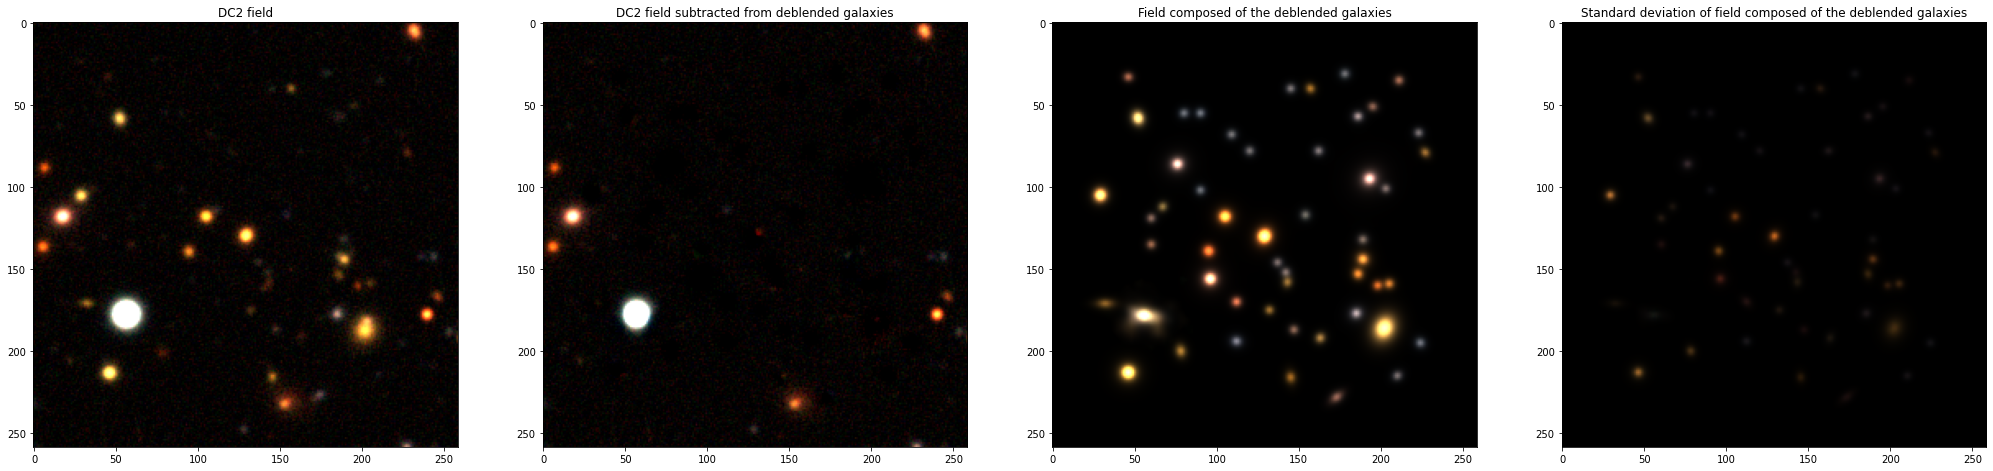

In [18]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(res_deblending_sep_meta['field_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_deblending_sep_meta['deblended_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_deblending_sep_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_deblending_sep_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')

We can see that there are still some residuals on the DC2 field subtracted from the deblended galaxies...

To improve this we can use the `optimize` module from `scipy` to look for the position that minimises the mean squared error between the true DC2 field and the one reconstructed from the deblended galaxies. For that we set the argument `optimise position` to **True**.

In [19]:
Deblender = DeblendField(net, field_img[0])
res_deblending_optimisation = Deblender.deblend_field(galaxy_distances_to_center_sep, optimise_positions=True)

Some galaxies are too close from the border of the field to be considered here.


In [20]:
res_deblending_optimisation_meta = Deblender.get_deblending_meta_data()

Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

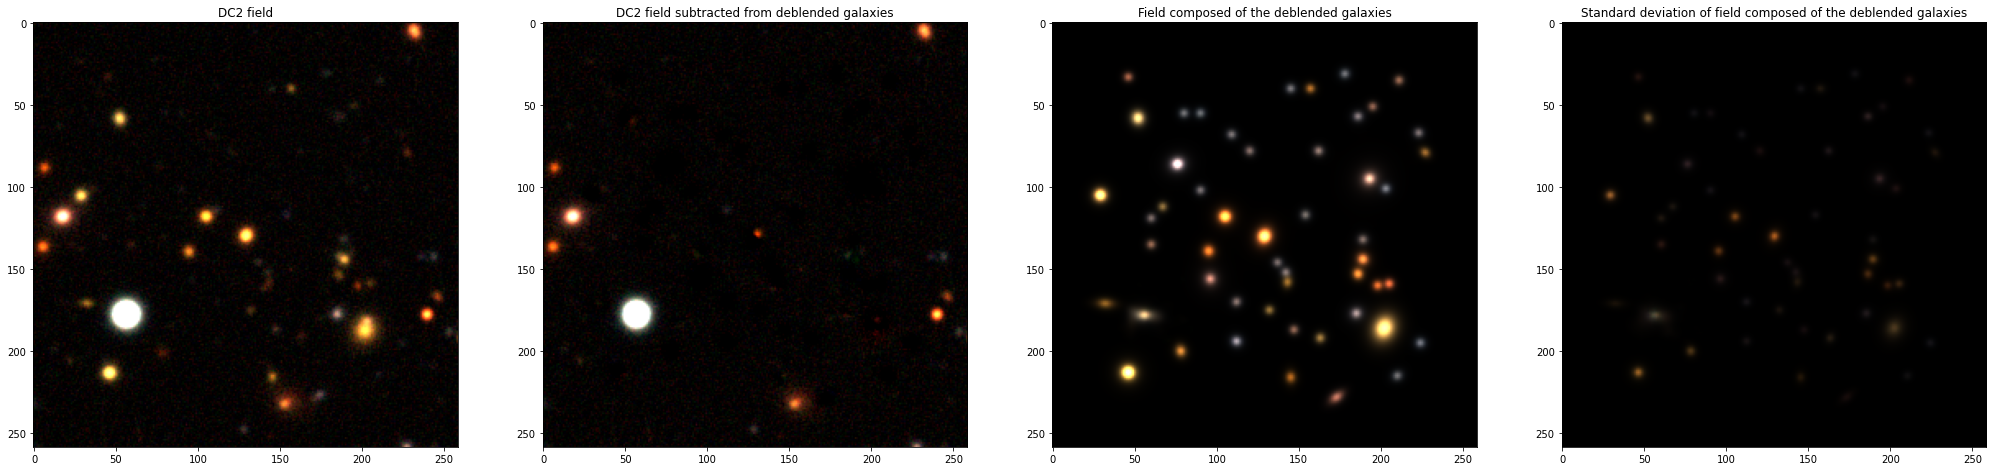

In [21]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(res_deblending_optimisation_meta['field_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_deblending_optimisation_meta['deblended_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_deblending_optimisation_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_deblending_optimisation_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')

We see that there are less residuals, for example for the galaxy below the bright star or for the bright ones in the of the field.

#### Comparison with DC2 truth catalog

For comparison we also take the coordinates of the galaxies from the truth catalog (with a magnitude cut at 26 in the $r$-band).

In [22]:
galaxies_coord_truth = all_field_galaxies_distances_from_center_truth
field_center = field_galaxies_distances_from_center[0]

In [23]:
galaxy_distances_to_center = []
for i in range(galaxies_coord_truth.shape[0]):
    galaxy_distances_to_center.append((int(-field_center[1]+galaxies_coord_truth[i][1]), int(-field_center[0]+galaxies_coord_truth[i][0])))

galaxy_distances_to_center=np.array(galaxy_distances_to_center)

In [24]:
print('There are '+str(len(galaxy_distances_to_center))+' galaxies that have a magnitude below 26 in the r-band on this field')

There are 43 galaxies that have a magnitude below 26 in the r-band on this field


Now do the deblending:

In [25]:
import time
t0 = time.time()
Deblender = DeblendField(net, field_img[0])
res_deblending = Deblender.deblend_field(galaxy_distances_to_center, optimise_positions=False)
print('The deblending of the field took '+str(time.time()-t0)+' seconds.')

Some galaxies are too close from the border of the field to be considered here.
The deblending of the field took 0.9995346069335938 seconds.


In [26]:
res_deblending_meta = Deblender.get_deblending_meta_data()

In [27]:
print('On the '+ str(Deblender.nb_of_detected_objects[0]) +' galaxies detected, '+str(Deblender.nb_of_deblended_galaxies[0]) +' were actually deblended.')

On the 43 galaxies detected, 37 were actually deblended.


And look at the resulting fields with red crosses superposed to the field on the positions of the galaxies from the truth catalog below a magnitude of 26 in the $r$-band.

Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

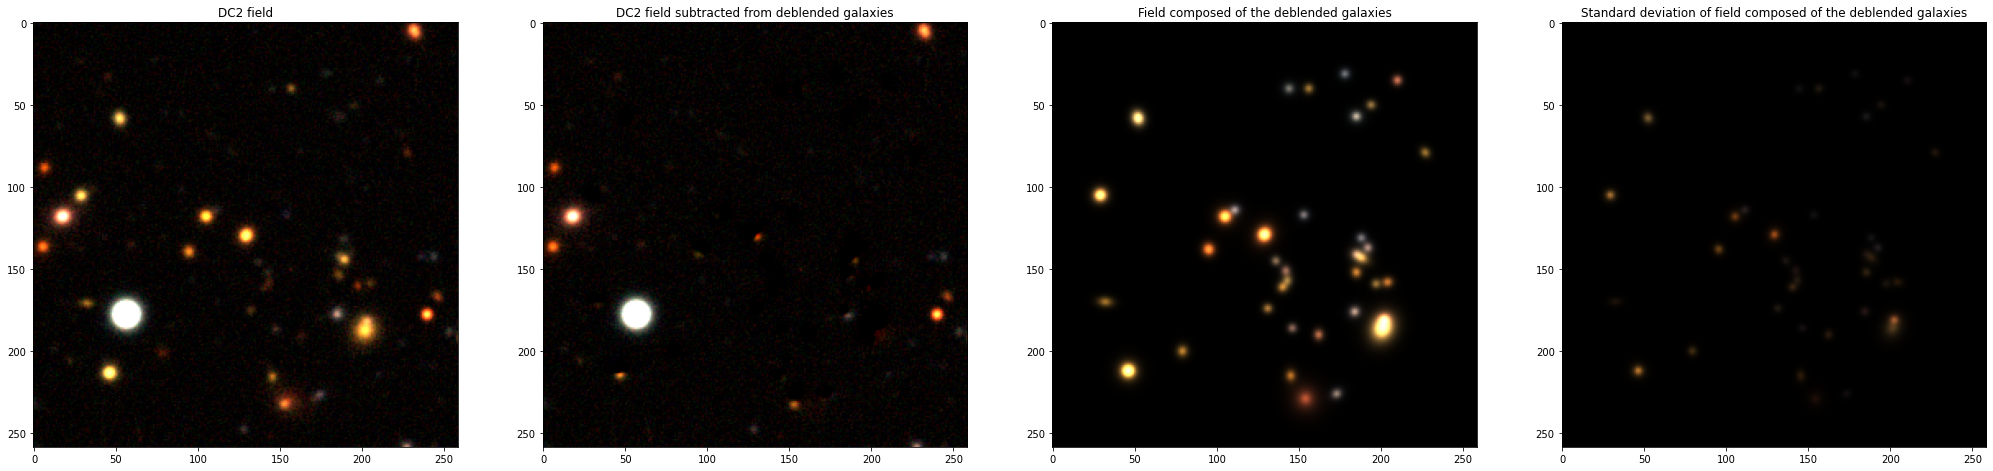

In [28]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(res_deblending_meta['field_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_deblending_meta['deblended_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_deblending_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_deblending_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')

Now we can check if we had the correct positions with SExtractor and compare the two deblended fields:

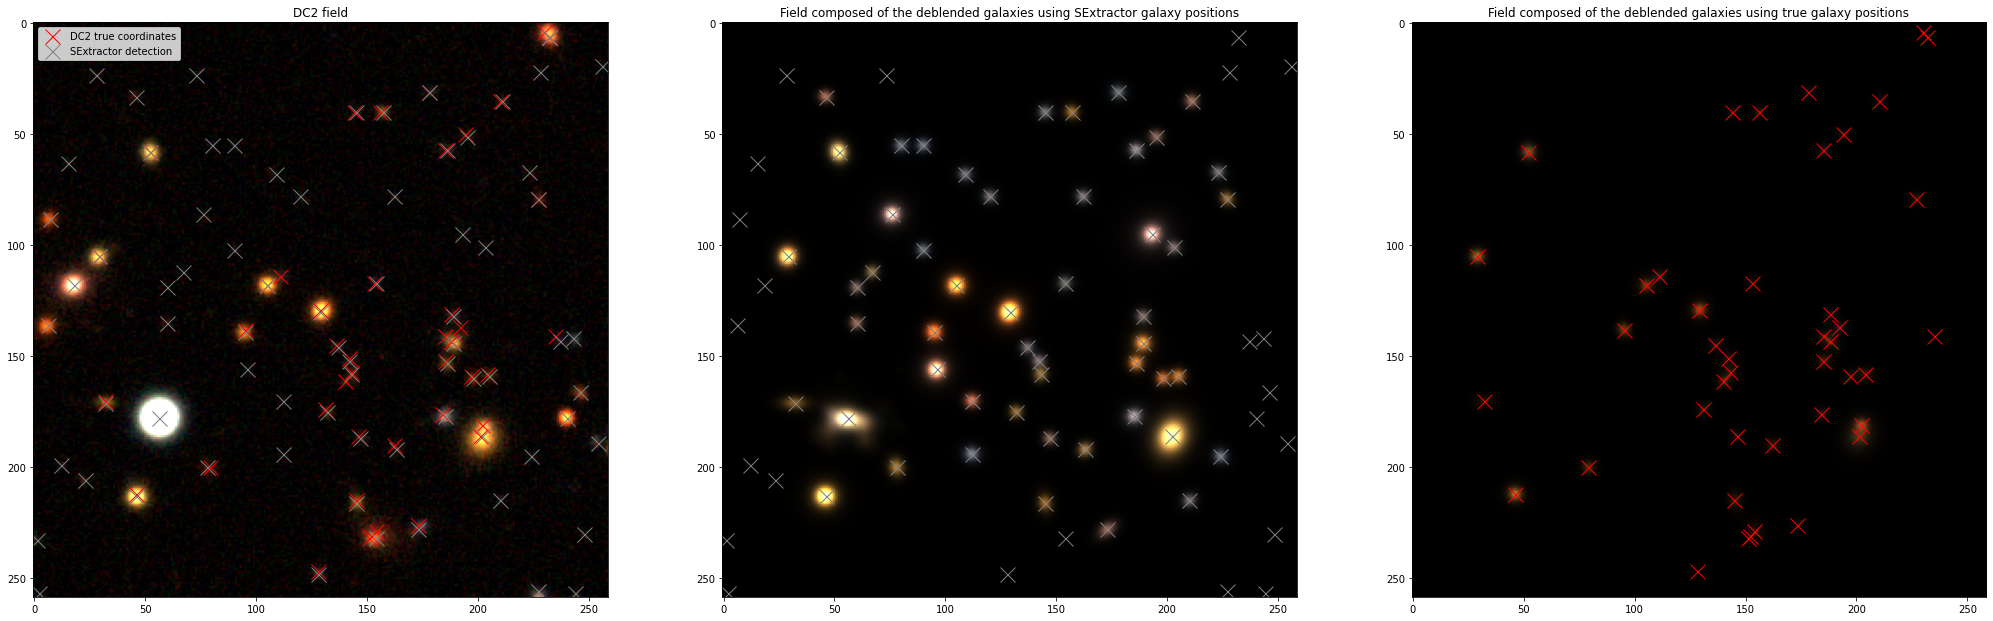

In [29]:
bands = [3,2,1]

fig, axes = plt.subplots(1,3, figsize = (35,15))
axes[0].imshow(np.clip(res_deblending_meta['field_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_deblending_sep_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_deblending_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))

for i in range(len(galaxy_distances_to_center)):
    if i==0:
        axes[0].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15, label = 'DC2 true coordinates')
    axes[0].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)
    axes[2].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)
for i in range(len(galaxy_distances_to_center_sep)):
    if i==0:
        axes[0].plot(np.round(int(field_size/2)+galaxy_distances_to_center_sep[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center_sep[i][0]), 'x', color = 'grey', markersize = 15, label = 'SExtractor detection')
    axes[0].plot(np.round(int(field_size/2)+galaxy_distances_to_center_sep[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center_sep[i][0]), 'x', color = 'grey', markersize = 15)
    axes[1].plot(np.round(int(field_size/2)+galaxy_distances_to_center_sep[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center_sep[i][0]), 'x', color = 'grey', markersize = 15)

axes[0].set_title('DC2 field')
axes[1].set_title('Field composed of the deblended galaxies using SExtractor galaxy positions')
axes[2].set_title('Field composed of the deblended galaxies using true galaxy positions')
axes[0].legend()

So we see that SExtractor found most of the true galaxies that have a magnitude below 26 in the $r$-band, and even some with at larger magnitudes. However, it fails for some of them, mostly when two galaxies are very close from one another (see in the lower right and in the middle at the bright galaxy for example). To find these residuals galaxies, we need to use an iterative procedure, re-running the detection on the denoised field to see if there are any remaining galaxies that became detectable after the first deblending pass.

**Note**: it is also possible to provide the cutout images directly to the deblended function is you already have extracted them using another algorithm. To do so, you must feed them to the `cutout_images` argument as shown below:

### Iterative deblending

With `debvader` it is possible to use the `iterative_deblending` function.

This method extracts the galaxies iteratively. In the example below, no coordinates are provided as first step, but it can be done by feeding them to the `galaxy_distances_to_center` argument.

#### Iterative deblending with SExtractor 

In [30]:
import time
t0=time.time()
res_iterative_procedure = Deblender.iterative_deblending(optimise_positions=False)
print('time: '+str(time.time()-t0))

Some galaxies are too close from the border of the field to be considered here.
Deblend 51 more galaxy(ies)
iteration 1
Some galaxies are too close from the border of the field to be considered here.
Deblend 17 more galaxy(ies)
105 galaxies found up to this step.
deta_mse = -1, mse_iteration = 0.0185296736945309 and mse_previous_step = 0.019109258562278304
converged !
time: 1.833536148071289


In [31]:
res_iterative_procedure_meta = Deblender.get_deblending_meta_data()

In [32]:
np.array(res_iterative_procedure['output_images_mean']).shape

(68,)

We have deblended 5 more galaxies than with a single path. We can compare with the previously deblended field.

Text(0.5, 1.0, 'Field composed of the deblended galaxies with iterative procedure\n minus the one with a single pass of SExtractor')

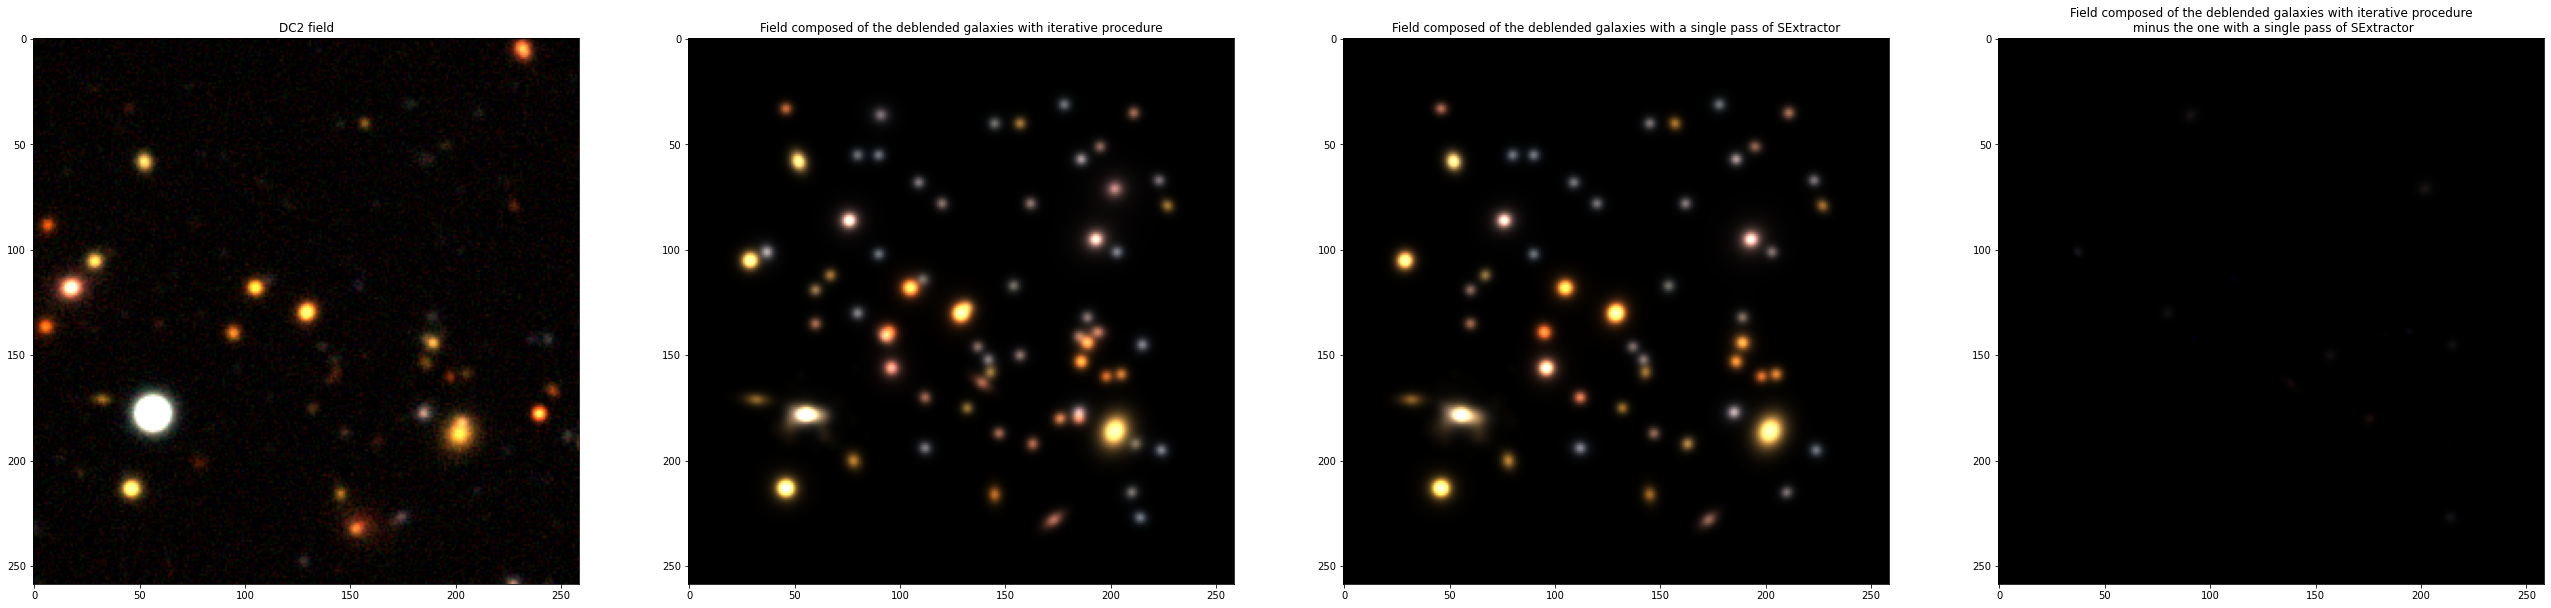

In [33]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (45,15))
axes[0].imshow(np.clip(res_iterative_procedure_meta['field_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_iterative_procedure_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_deblending_sep_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_iterative_procedure_meta['predicted_stddev_field'][:,:,bands]- res_deblending_sep_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('Field composed of the deblended galaxies with iterative procedure')
axes[2].set_title('Field composed of the deblended galaxies with a single pass of SExtractor')
axes[3].set_title('Field composed of the deblended galaxies with iterative procedure\n minus the one with a single pass of SExtractor')

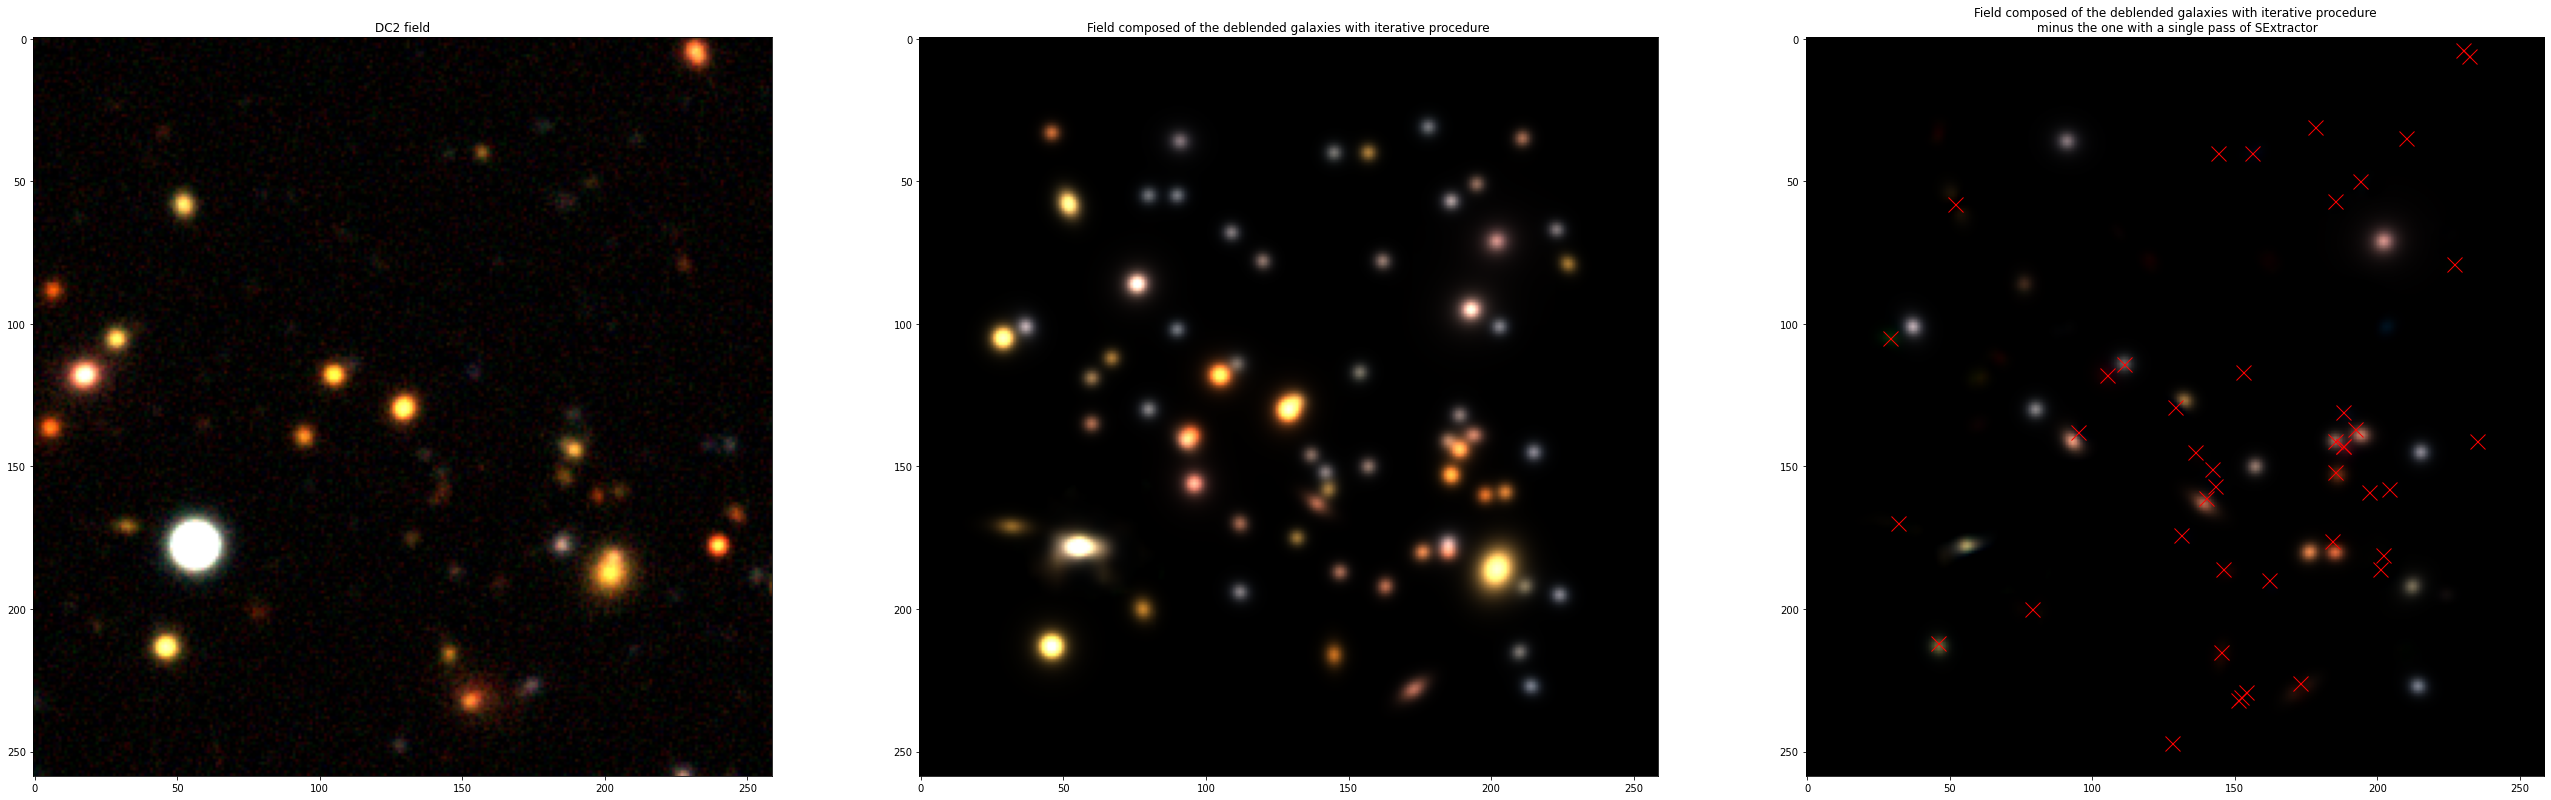

In [34]:
bands = [3,2,1]

fig, axes = plt.subplots(1,3, figsize = (45,15))
axes[0].imshow(np.clip(res_iterative_procedure_meta['field_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_iterative_procedure_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_iterative_procedure_meta['predicted_mean_field'][:,:,bands]- res_deblending_sep_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('Field composed of the deblended galaxies with iterative procedure')
axes[2].set_title('Field composed of the deblended galaxies with iterative procedure\n minus the one with a single pass of SExtractor')

for i in range(len(galaxy_distances_to_center)):
    if i==0:
        axes[2].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15, label = 'DC2 true coordinates')        
    axes[2].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)


Interestingly, as shown on the previous plot on the right, these six galaxies are true galaxies from the DC2 simulation (TO CONFIRM WITH DC2 DATA). We consequently increased our number of usable galaxies by 5 compared to 36 before. A $14$% increase in the number of usable galaxies.

It is also possible to access simply the different cutouts and the deblended galaxies from the cutouts. We plot only r-band here, but the output images are multi-bands (ugrizy)::

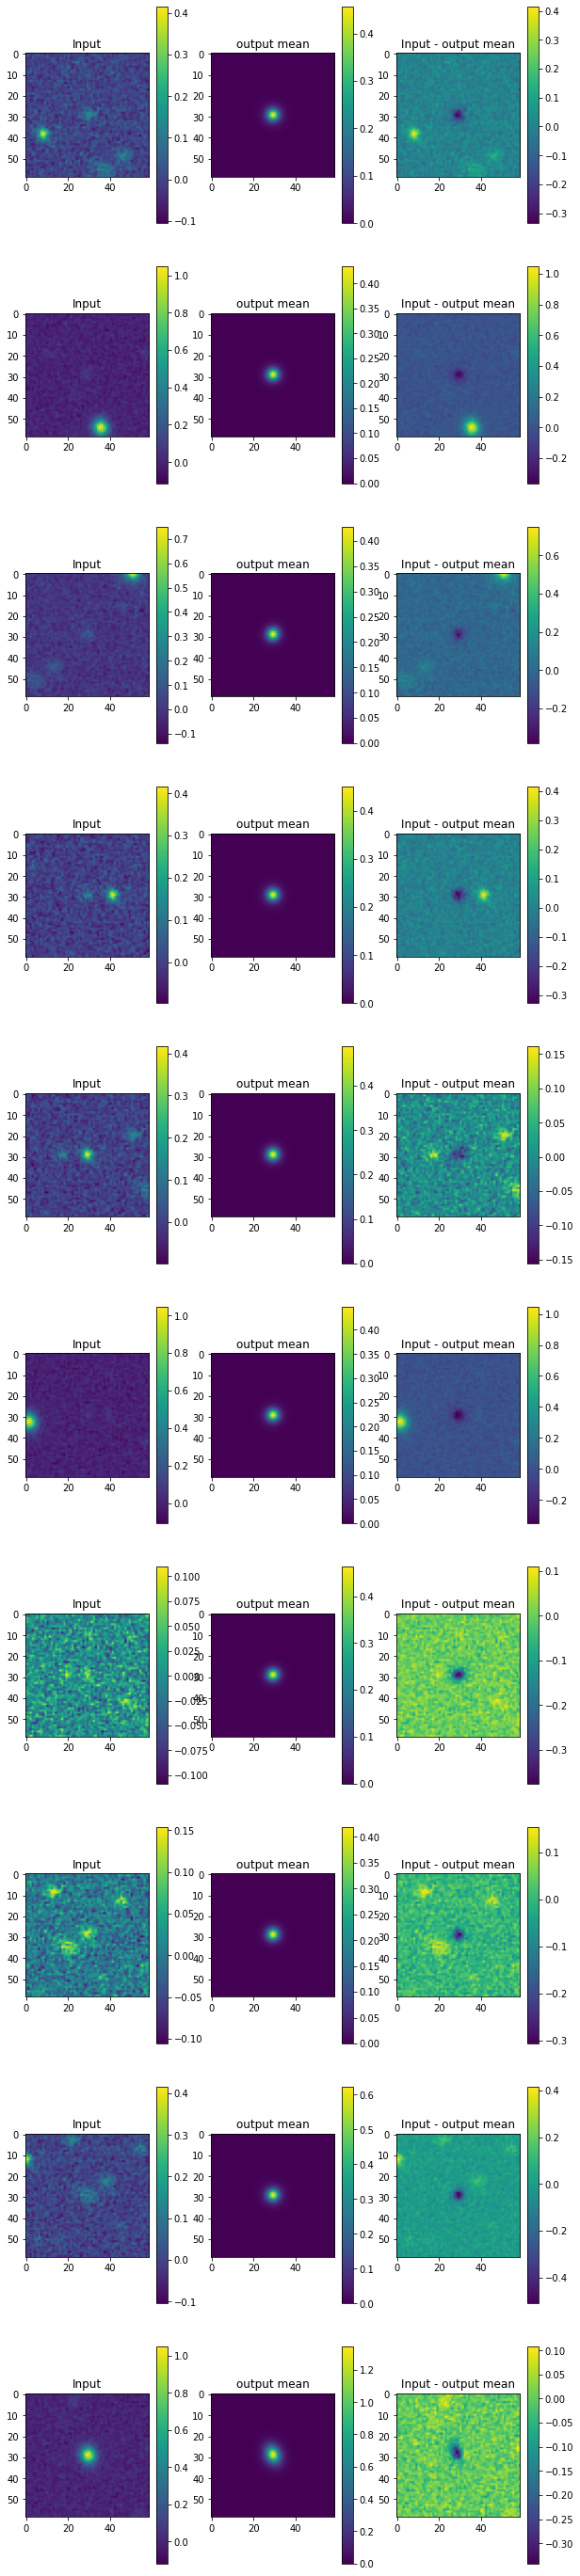

In [35]:
fig, axes = plt.subplots(10,3, figsize = (10, 50))
for i in range (10):
    f1 = axes[i,0].imshow(res_iterative_procedure['cutout_images'][i][:,:,2])
    f2 = axes[i,1].imshow(res_iterative_procedure['output_images_mean'][i][:,:,2])
    f3 = axes[i,2].imshow(res_iterative_procedure['cutout_images'][i][:,:,2]-res_iterative_procedure['output_images_mean'][i][:,:,2])
    
    fig.colorbar(f1, ax = axes[i,0])
    fig.colorbar(f2, ax = axes[i,1])
    fig.colorbar(f3, ax = axes[i,2])
    
    axes[i,0].set_title('Input')
    axes[i,1].set_title('output mean')
    axes[i,2].set_title('Input - output mean')

#### Two other DC2 field examples

Here we show the example for two other fields taken randomly within the DC2 simulation.

##### First example

In [36]:
field_img = np.load(data_folder_path + 'dc2_imgs/field/field_img_2.npy', mmap_mode = 'c') # DC2 field image
all_field_galaxies_distances_from_center_truth = np.load(data_folder_path+'dc2_imgs/field/gal_coordinates_complete_truth_catalog_2.npy', allow_pickle=True) # Distances from center of the field for the galaxies from the DC2 truth catalog (in pixels). Mag cut at 26
field_center = np.load(data_folder_path+'dc2_imgs/field/field_center_2.npy')

Deblender = DeblendField(net, field_img[0], epistemic_uncertainty_estimation=False)
res_iterative_procedure = Deblender.iterative_deblending(galaxy_distances_to_center=None,
                                              optimise_positions=True,
                                              epistemic_criterion= 20,
                                              mse_criterion=0.5)
res_iterative_procedure_meta = Deblender.get_deblending_meta_data()

Some galaxies are too close from the border of the field to be considered here.
Deblend 45 more galaxy(ies)
iteration 1
Some galaxies are too close from the border of the field to be considered here.
Deblend 18 more galaxy(ies)
63 galaxies found up to this step.
deta_mse = -1, mse_iteration = 0.021421649461890572 and mse_previous_step = 0.01608952845329436
converged !


Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

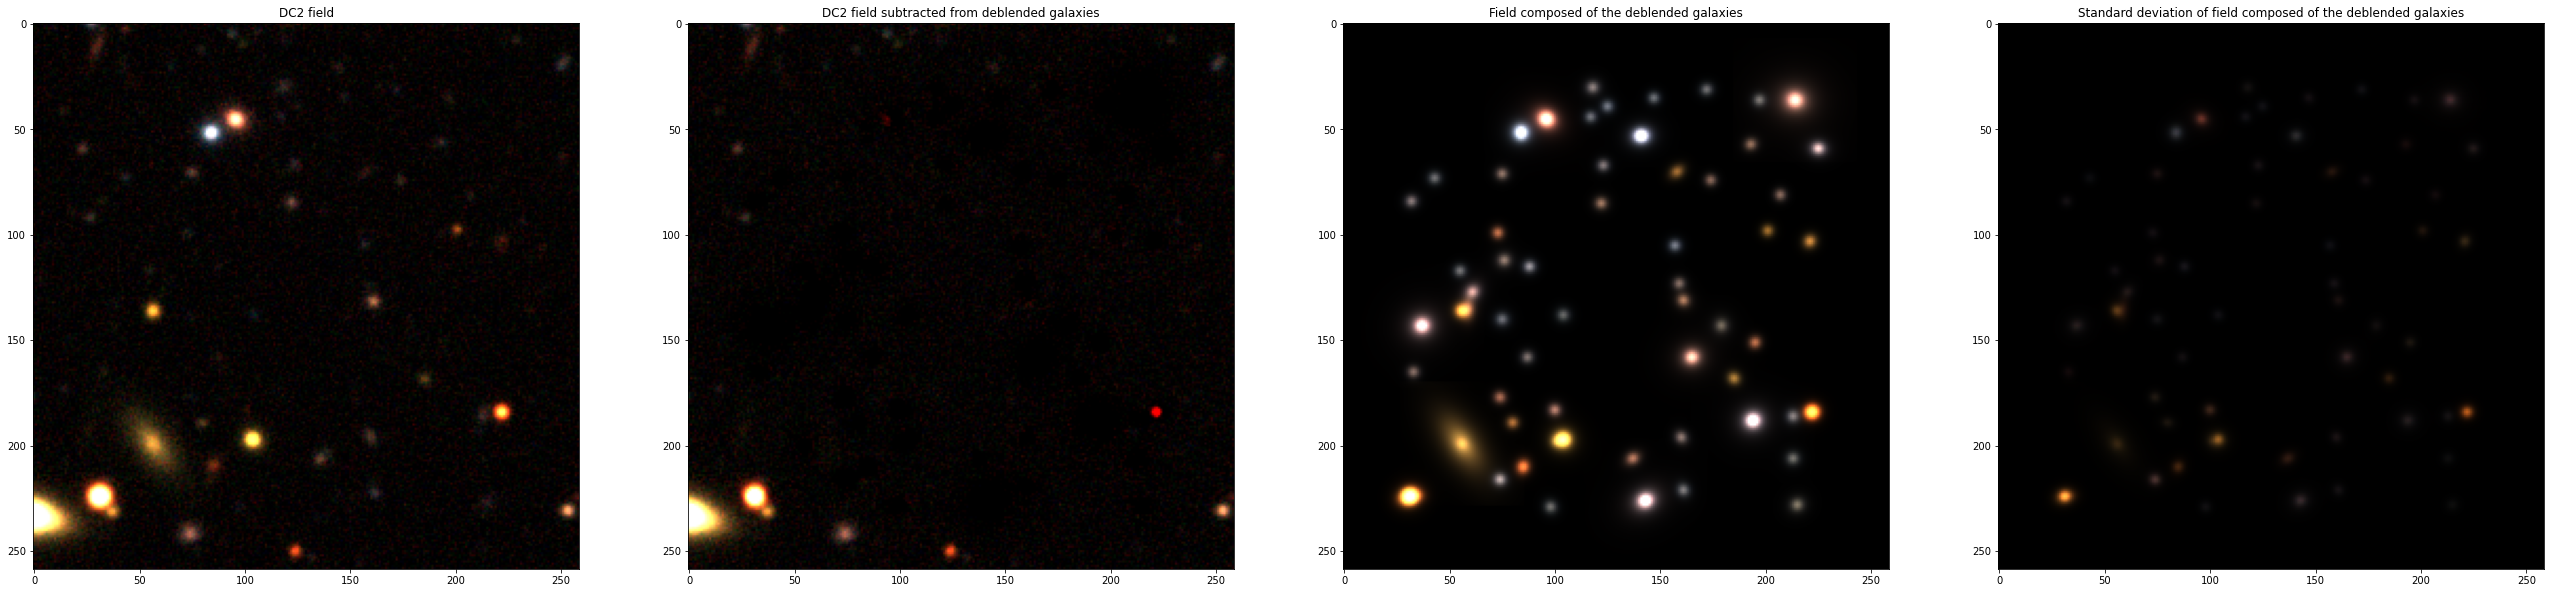

In [37]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (45,15))
axes[0].imshow(np.clip(res_iterative_procedure_meta['field_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_iterative_procedure_meta['deblended_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_iterative_procedure_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_iterative_procedure_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))
#axes[4].imshow(np.clip(res_iterative_procedure['model_image_epistemic_uncertainty'][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')
#axes[4].set_title('Epistemic uncertainty of field composed of the deblended galaxies')

In [38]:
galaxy_distances_to_center = []
for i in range(all_field_galaxies_distances_from_center_truth.shape[0]):
    galaxy_distances_to_center.append((int(np.round(-field_center[1]+all_field_galaxies_distances_from_center_truth[i][1])), int(np.round(-field_center[0]+all_field_galaxies_distances_from_center_truth[i][0]))))

galaxy_distances_to_center=np.array(galaxy_distances_to_center)

In [ ]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(res_iterative_procedure_meta['field_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_iterative_procedure_meta['deblended_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_iterative_procedure_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_iterative_procedure_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))

for i in range(len(galaxy_distances_to_center)):
    axes[0].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)
    axes[1].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)
    axes[2].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)


axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')

Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

##### Second example

In [ ]:
field_img = np.load(data_folder_path+'dc2_imgs/field/field_img_3.npy', mmap_mode = 'c') # DC2 field image
all_field_galaxies_distances_from_center_truth = np.load(data_folder_path+'dc2_imgs/field/gal_coordinates_complete_truth_catalog_3.npy', allow_pickle=True) # Distances from center of the field for the galaxies from the DC2 truth catalog (in pixels). Mag cut at 26
field_center = np.load(data_folder_path+'dc2_imgs/field/field_center_3.npy')

Deblender = DeblendField(net, field_img[0], epistemic_uncertainty_estimation=False)
res_iterative_procedure = Deblender.iterative_deblending(galaxy_distances_to_center=None,
                                              optimise_positions=True,
                                              epistemic_criterion= 20,
                                              mse_criterion=0.5)

res_iterative_procedure_meta = Deblender.get_deblending_meta_data()

In [ ]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (45,15))
axes[0].imshow(np.clip(res_iterative_procedure_meta['field_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_iterative_procedure_meta['deblended_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_iterative_procedure_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_iterative_procedure_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))
#axes[4].imshow(np.clip(res_iterative_procedure['model_image_epistemic_uncertainty'][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')
#axes[4].set_title('Epistemic uncertainty of field composed of the deblended galaxies')

In [ ]:
galaxy_distances_to_center = []
for i in range(all_field_galaxies_distances_from_center_truth.shape[0]):
    galaxy_distances_to_center.append((int(-field_center[1]+all_field_galaxies_distances_from_center_truth[i][1]), int(-field_center[0]+all_field_galaxies_distances_from_center_truth[i][0])))

galaxy_distances_to_center=np.array(galaxy_distances_to_center)

In [ ]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(res_iterative_procedure_meta['field_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_iterative_procedure_meta['deblended_image'][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_iterative_procedure_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_iterative_procedure_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))

for i in range(len(galaxy_distances_to_center)):
    axes[0].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)
    axes[1].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)
    axes[2].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)


axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')